# Implementing Shor's algorithm (**Graded Lab Session**)

Here, we are only interested in the part of the algorithm solving the period-finding function.


## To hand out

1. A **report** with your answers in a **PDF FILE** (made out of LaTeX, libreoffice, ...)
  * Math and text answers
  * The code for the circuits
  * Screenshot of figures/circuits
  * python answers and results of runs
  * *etc*
  
2. **This notebook**
  * as a runnable script



But first, some libraries to load (nothing to modify here)

In [2]:
# Uncomment if needed
#! python -m pip install matplotlib
#! python -m pip install qiskit qiskit-aer

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi, gcd
from qiskit import *
from qiskit.circuit import *
from qiskit.circuit.library import *
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator, StatevectorSimulator
from scipy import optimize
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']



## A few useful functions

- `nat2bl` : from a natural number to a list of `0` and `1` (low-end bit on the right)
- `nat2bs` : from a natural number to a string such as `"010010011"`
- `bl2bs` : from a list to a string
- ... and all of the functions in the other direction.

In [38]:
def nat2bl(pad,n):
    if n == 0 :
        return [0 for i in range(pad)]
    elif n % 2 == 1:
        r = nat2bl(pad-1,(n-1)//2)
        r.append(1)
        return r
    else:
        r = nat2bl(pad-1,n//2)
        r.append(0)
        return r

for i in range(16):
    print(nat2bl(5,i))

[0, 0, 0, 0, 0]
[0, 0, 0, 0, 1]
[0, 0, 0, 1, 0]
[0, 0, 0, 1, 1]
[0, 0, 1, 0, 0]
[0, 0, 1, 0, 1]
[0, 0, 1, 1, 0]
[0, 0, 1, 1, 1]
[0, 1, 0, 0, 0]
[0, 1, 0, 0, 1]
[0, 1, 0, 1, 0]
[0, 1, 0, 1, 1]
[0, 1, 1, 0, 0]
[0, 1, 1, 0, 1]
[0, 1, 1, 1, 0]
[0, 1, 1, 1, 1]


In [39]:
def bl2nat(s):
    if len(s) == 0:
        return 0
    else:
        a = s.pop()
        return (a + 2*bl2nat(s))

def bl2bs(l):
    if len(l) == 0:
        return ""
    else:
        a = l.pop()
        return (bl2bs(l) + str(a))

def nat2bs(pad,i):
    return bl2bs(nat2bl(pad,i))

def bs2bl(s):
    l = []
    for i in range(len(s)):
        l.append(int(s[i]))
    return l

def bs2nat(s):
    return bl2nat(bs2bl(s))


print(nat2bs(10,17))
print(bs2nat("0011010"))



0000010001
26


The plotting functions

In [40]:

def plotDistrib(d):
    sorted_items = sorted(d.items())
    keys = [k for k, _ in sorted_items]
    values = [v for _, v in sorted_items]
    plt.figure()
    plt.bar(keys, values)
    plt.xticks(rotation=90)
    plt.show()

def getSample(qc,howmany):
    simulator = AerSimulator()
    job = simulator.run(qc.decompose(reps=12), shots=howmany)
    res = dict(job.result().get_counts(qc))
    return res

def plotSample(qc,howmany):
    d = getSample(qc,howmany)
    ld = len(list(d.keys())[0])
    for i in range(2 ** ld):
        s = nat2bs(ld,i)
        if s not in d: d[s] = 0
    plotDistrib(d)

# 1 - Introduction

In this lab session we are going to code the heart of Shor's algorithm: the circuit making it possible to find the period of the function

$$
x \mapsto a^x mod N.
$$

We first need to code the oracle computing the multiplication modulo, then to combined it with QPE.

**Objective** : Only to convince yourself that the number we are looking for can be recovered from the final distribution.

Let's go.

# 2 - Oracle synthesis

The function $f : x\mapsto (a^p\cdot x)~mod~N$ is a bijection of $\{0...N-1\}$ to $\{0...N-1\}$ if $a$ and $N$ are co-primes. 

In this case, we can consider $f$ as a unitary operator acting on a Hilbert space of dimension $N$.
One can then consider $f$ as a unitary acting on a register of qubits, provided that $N$ is a power of $2$.

This is a bit limited : we want to be able to consider arbitrary numbers $N$. We then instead consider the function:
$$
Mult_{a^p~mod~N} : x\mapsto 
\left\{
\begin{array}{ll}
(a^p\cdot x)~mod~N & \text{si }x < N
\\
x & \text{si} N \leq x < 2^n
\end{array}\right.
$$
provided that $N<2^n$.

This new function $Mult_{a^p~mod~N}$ is indeed a bijection of $\{0..2^n\}$: we are going to implement this one instead. Here, we are making something simple, using the automated circuit synthesis of QisKit. It is not the most efficient, but it is the easiest for our purpose.

To clarify what is expected, let us consider the code for $Mult_{2^3~mod~13}$, that is, $Mult_{8~mod~13}$. To store all of the numbers from $0$ to $12$ we need $4$ bits. The table for the operation $Mult_{8~mod~13}$ is as follows. We first write it using decimal numbers, then with the binary decomposition. Note how starting from $x=13$ we are just padding to complete to $15 = 2^4-1$.

$$\begin{array}{l|l|l|l}
\text{x} & \text{result} & \text{x (binary)} & \text{result (binary)}
\\\hline
0  &  0       & 0000       & 0000            \\
1  &  8       & 0001       & 1000            \\
2  &  3       & 0010       & 0011            \\
3  &  11      & 0011       & 1011            \\
4  &  6       & 0100       & 0110            \\
5  &  1       & 0101       & 0001            \\
6  &  9       & 0110       & 1001            \\
7  &  4       & 0111       & 0100            \\
8  &  12      & 1000       & 1100            \\
9  &  7       & 1001       & 0111            \\
10 &  2       & 1010       & 0010            \\
11 &  10      & 1011       & 1010            \\
12 &  5       & 1100       & 0101
\\\hline
13 & 13       & 1101       & 1101            \\
14 & 14       & 1110       & 1110            \\
15 & 15       & 1111       & 1111
\end{array}
$$

The corresponding matrix is then

$$
\begin{array}{ccccccccccccc|ccc}
1&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&1&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&1&0&0&0&0&0\\
0&0&1&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&1&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&1&0&0&0\\
0&0&0&0&1&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&1&0&0&0&0&0&0\\
0&1&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&1&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&1&0&0&0&0\\
0&0&0&1&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&1&0&0&0&0&0&0&0\\\hline
0&0&0&0&0&0&0&0&0&0&0&0&0&1&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&1&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&1\\
\end{array}
$$

The top-left block corresponds to the permutation matrix : $|0010\rangle$ is for instance sent to $|0011\rangle$ (i.e. $2$ is sent to $3$). The bottom-right block corresponds to the padding with identity, to build an unitary matrix defined on the whole space.

## **TODO** - Operator for the multiplication modulo.

- Complete the following code so that `M` is a matrix implementing the bijection $Mult_{a^p~mod~N}$.
- Test it with the code below it, with $a = 1, 3, 6, 11, 15$.

In [122]:
# a, p, N et n are as above

def gateMult(a,p,N,n):
    nn = 2 ** n
    M = [[0 for x in range(nn)] for i in range(nn)]

    for i in range(nn):
        if i < N:
            dest = (pow(a, p, N) * i) % N
            M[dest][i] = 1
        else:
            M[i][i] = 1 
    
    U = Operator(M)
    return(UnitaryGate(U))

In [123]:
# Code to test the circuit above, on n qubits

# VALUES TO POSSIBLY CHANGE
# BEWARE to keep x and N < 2^n
x = 3
a = 2
p = 4
N = 11
n = 4

# TEST TO NOT CHANGE

phi = QuantumRegister(n)
cphi = ClassicalRegister(n)

qc = QuantumCircuit(phi,cphi)
vl = nat2bl(n,x)
print(f"Input : {str(vl)} (= {x} en décimal)")
vl.reverse() # Change where the least significant bit is placed
for i in range(len(vl)):
    if vl[i] == 1:
        qc.x(phi[i])

qc.append(gateMult(a,p,N,n),list(phi))
qc.measure(phi,cphi)

simulator = AerSimulator()
job = simulator.run(qc, shots=1024)
d = dict(job.result().get_counts(qc))

assert(len(d) == 1)
s =  list(d.keys())[0]

if x < 11:
    print(f"Correct answer should be {x} * {a}^{p} mod {N} = {(x*(a ** p)) % N}")
else:
    print(f"We are above {N} so this should be the identity")
print(f"The circuit answer: {s} (= {bs2nat(s)} in decimal)")

# If you run it, it should print a log of what is expected and what is indeed computed.

Input : [0, 0, 1, 1] (= 3 en décimal)
Correct answer should be 3 * 2^4 mod 11 = 4
The circuit answer: 0100 (= 4 in decimal)


# 3 - Plugging everything together : Shor

We are now ready to realize Shor's algorithm

## Questions (**TODO**)

### Q 3.1 The circuit

Realize the circuit:
- Copy-paste the code of QPE, with 4 qbits of precision for `eig`
- Introduce our home-made unitary : choose 5 qbits pour `phi`
- Place `phi` in the state corresponding to the integer $1$ in decimal (beware of the position of the low-end bit)

In [120]:
a=7
N=30
n=5

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT

def QPE(U, size_eig=4, size_phi=5, endMeasure=True, do_swaps=True):
    """Phase estimation of unitary U acting on the 'phi' register.
    - Infers target size from U.num_qubits
    - Optional eigenstate preparation on phi (|11..1>)
    - Uses inverse QFT with optional swaps so measurement order is MSB..LSB
    """
    eig  = QuantumRegister(size_eig, "eig")
    phi  = QuantumRegister(size_phi, "phi")
    qc   = QuantumCircuit(eig, phi, name="QPE")
    qc.x(phi[0])
    
    if endMeasure:
        ceig = ClassicalRegister(size_eig, "ceig")
        qc.add_register(ceig)
    qc.h(eig)
   
    qc.barrier()
    for j in range(size_eig):
        U_pow = U.power(2**j)
        qc.append(U_pow.control(1), [eig[j]] + list(phi))
    qc.barrier()
    qc.append(QFT(num_qubits=size_eig, inverse=True, do_swaps=do_swaps), eig)
    if endMeasure:
        qc.measure(eig, ceig)
    return qc
    
qc = QPE(gateMult(a,1,N,n))
qc.draw()

C:\Users\PAL WEB\AppData\Local\Temp\ipykernel_14396\3309745784.py:29: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(num_qubits=size_eig, inverse=True, do_swaps=do_swaps), eig)


┌───┐ ░                                                          ░ »
 eig_0: ┤ H ├─░───────■──────────────────────────────────────────────────░─»
        ├───┤ ░       │                                                  ░ »
 eig_1: ┤ H ├─░───────┼─────────────■────────────────────────────────────░─»
        ├───┤ ░       │             │                                    ░ »
 eig_2: ┤ H ├─░───────┼─────────────┼─────────────■──────────────────────░─»
        ├───┤ ░       │             │             │                      ░ »
 eig_3: ┤ H ├─░───────┼─────────────┼─────────────┼─────────────■────────░─»
        ├───┤ ░ ┌─────┴──────┐┌─────┴──────┐┌─────┴──────┐┌─────┴──────┐ ░ »
 phi_0: ┤ X ├─░─┤0           ├┤0           ├┤0           ├┤0           ├─░─»
        └───┘ ░ │            ││            ││            ││            │ ░ »
 phi_1: ──────░─┤1           ├┤1           ├┤1           ├┤1           ├─░─»
              ░ │            ││            ││            ││            │ ░ »
 phi_2: ──────░─┤2 unitary^1 ├┤2 unitary^2 ├┤2 unitary^4 ├┤2 unitary^8 ├─░─»
              ░ │            ││            ││            ││            │ ░ »
 phi_3: ──────░─┤3           ├┤3           ├┤3           ├┤3           ├─░─»
              ░ │            ││            ││            ││            │ ░ »
 phi_4: ──────░─┤4           ├┤4           ├┤4           ├┤4           ├─░─»
              ░ └────────────┘└────────────┘└────────────┘└────────────┘ ░ »
ceig: 4/═══════════════════════════════════════════════════════════════════»
                                                                           »
«        ┌───────┐┌─┐         
« eig_0: ┤0      ├┤M├─────────
«        │       │└╥┘┌─┐      
« eig_1: ┤1      ├─╫─┤M├──────
«        │  IQFT │ ║ └╥┘┌─┐   
« eig_2: ┤2      ├─╫──╫─┤M├───
«        │       │ ║  ║ └╥┘┌─┐
« eig_3: ┤3      ├─╫──╫──╫─┤M├
«        └───────┘ ║  ║  ║ └╥┘
« phi_0: ──────────╫──╫──╫──╫─
«                  ║  ║  ║  ║ 
« phi_1: ──────────╫──╫──╫──╫─
«                  ║  ║  ║  ║ 
« phi_2: ──────────╫──╫──╫──╫─
«                  ║  ║  ║  ║ 
« phi_3: ──────────╫──╫──╫──╫─
«                  ║  ║  ║  ║ 
« phi_4: ──────────╫──╫──╫──╫─
«                  ║  ║  ║  ║ 
«ceig: 4/══════════╩══╩══╩══╩═
«                  0  1  2  3

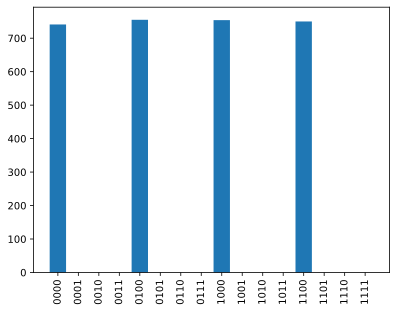

In [121]:
# Then we can run things and plot the results
plotSample(qc, 3000)

### Q 3.2 Analysis (**TODO**)

- On the drawing, what are the axes? Where are we supposed to see the values $\frac{s}{r}$ ? The horizontal axis is graded with integers... To what real numbers between 0 and 1 these correspond to ?
- What is the order $r$ of $a$ mod $N$ (here $7$ mod $30$) ?
- Where do you read this value on the graph ? Explain.
- Change a and N respectively to 20 and 29. Can you read the value $r$ ? Is it correct ? Show the graph in your report, and explain everything that you see.
- The drawing is not very precise... How to make it better ? Show the restult in your report, and explain why it is better.
- Is it still working if you change the value of `a` and/or `N` to other values ? Show what you get, and explain. Beware not to use too large values for `N`... To get some inspiration, below is the list of possibilities up to 31.

**RATIONAL** I will grade your answer on your ability to show me that you understand what is happening with your code.

#### Report in the separate report:
* your code
* screenshots of circuits
* the results of your runs
* screenshots of plots 
* answers to questions and discussion

In [89]:
for N in range(3,32):
    for a in range(2,N):
        if gcd(a,N) == 1:
            for p in range(1,N):
                if (a ** p) % N == 1:
                    break
            print(f"Order of {a} mod {N}: {p}")

Order of 2 mod 3: 2
Order of 3 mod 4: 2
Order of 2 mod 5: 4
Order of 3 mod 5: 4
Order of 4 mod 5: 2
Order of 5 mod 6: 2
Order of 2 mod 7: 3
Order of 3 mod 7: 6
Order of 4 mod 7: 3
Order of 5 mod 7: 6
Order of 6 mod 7: 2
Order of 3 mod 8: 2
Order of 5 mod 8: 2
Order of 7 mod 8: 2
Order of 2 mod 9: 6
Order of 4 mod 9: 3
Order of 5 mod 9: 6
Order of 7 mod 9: 3
Order of 8 mod 9: 2
Order of 3 mod 10: 4
Order of 7 mod 10: 4
Order of 9 mod 10: 2
Order of 2 mod 11: 10
Order of 3 mod 11: 5
Order of 4 mod 11: 5
Order of 5 mod 11: 5
Order of 6 mod 11: 10
Order of 7 mod 11: 10
Order of 8 mod 11: 10
Order of 9 mod 11: 5
Order of 10 mod 11: 2
Order of 5 mod 12: 2
Order of 7 mod 12: 2
Order of 11 mod 12: 2
Order of 2 mod 13: 12
Order of 3 mod 13: 3
Order of 4 mod 13: 6
Order of 5 mod 13: 4
Order of 6 mod 13: 12
Order of 7 mod 13: 12
Order of 8 mod 13: 4
Order of 9 mod 13: 3
Order of 10 mod 13: 6
Order of 11 mod 13: 12
Order of 12 mod 13: 2
Order of 3 mod 14: 6
Order of 5 mod 14: 6
Order of 9 mod 14: 